In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = f"""
execution:
    exp_id: exp_012
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs
    cand_exp_dir: None
    use_cand: False

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [3]:
if CFG["dataset"]["use_cand"]:
    with open(os.path.join(CFG["dataset"]["cand_exp_dir"], "next_cands.pkl"), "rb") as f:
        next_cands = pickle.load(f)

## 特徴生成

In [4]:
def generate_features(train: pd.DataFrame):
    features = Features()

    # 時刻
    timestamp = pd.to_datetime(train["timestamp"].values[0])
    total_seconds = (timestamp - timestamp.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    train["total_seconds"] = (total_seconds + train.index * 5) % (24 * 60 * 60) # [sec]
    features.add_num_feature("total_seconds")    

    columns = ["anglez", "enmo"]

    # その人のその時刻での平均的な測定値
    gb = train.groupby("total_seconds")[columns].mean()
    gb.columns = [f"{c}_mean" for c in columns]
    train["anglez_mean"] = train["total_seconds"].map(gb["anglez_mean"])
    train["enmo_mean"] = train["total_seconds"].map(gb["enmo_mean"])
    features.add_num_features(gb.columns.tolist())
    columns += gb.columns.tolist()

    # diff
    f_names = [f"{c}_diff_abs" for c in columns]
    train[f_names] = train[columns].diff().abs()
    features.add_num_features(f_names)
    columns += f_names

    # rolling
    dts = [-1000, -100, -50, -10, 10, 50, 100, 1000]
    for dt in dts:            
        # rolling
        if dt > 0:
            f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).mean()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_std_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).std()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_max_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).max()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_min_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).min()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_median_{dt}" for c in columns]
            train[f_names] = train[columns].rolling(dt, center=True).median()
            features.add_num_features(f_names)

            f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
            train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
            features.add_num_features(f_names)


    # 一定stepで集約
    series_id = train["series_id"].values[0]
    agg_freq = CFG["feature"]["agg_freq"]
    columns = features.all_features() + ["target", "step"]
    train = train[columns].groupby(train["step"].values // agg_freq).mean()
    train["series_id"] = series_id
    train["target"] = train["target"].round().astype(int)

    # next_candsにないstepは除外
    if CFG["dataset"]["use_cand"]:
        cands = next_cands[series_id]
        train["reduce_step"] = train["step"].astype(int)
        train = train[train["reduce_step"].isin(cands)]

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

def read_and_generate_features(file):
    train = pd.read_csv(file)
    train, features = generate_features(train)
    return train, features

In [5]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.csv")

if CFG["execution"]["multiprocessing"]:
    with Pool(30) as pool:
        results = list(tqdm(pool.imap(read_and_generate_features, files), total=len(files)))
    dfs, features = zip(*results)
    train = pd.concat(dfs)
    features = features[0]
else:
    dfs = []
    for file in tqdm(files):
        train = pd.read_csv(file)
        train, features = generate_features(train)
        dfs.append(train)
    train = pd.concat(dfs)
    features = features[0]

100%|██████████| 277/277 [06:36<00:00,  1.43s/it]


## 学習

In [6]:
# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train = train.merge(cv_split, on=["series_id"], how="left")
display(train.head(5))
train.shape

,anglez_diff_abs,anglez_diff_abs_rolling_max_10,anglez_diff_abs_rolling_max_100,anglez_diff_abs_rolling_max_1000,anglez_diff_abs_rolling_max_50,anglez_diff_abs_rolling_mean_10,anglez_diff_abs_rolling_mean_100,anglez_diff_abs_rolling_mean_1000,anglez_diff_abs_rolling_mean_50,anglez_diff_abs_rolling_median_10,...,enmo_rolling_square_mean_50,enmo_rolling_std_10,enmo_rolling_std_100,enmo_rolling_std_1000,enmo_rolling_std_50,total_seconds,target,step,series_id,fold
0,0.006461,0.043200,NaN,NaN,NaN,0.007771,NaN,NaN,NaN,0.000428,...,NaN,0.000000,NaN,NaN,NaN,40557.5,1,11.5,af91d9a50547,3
1,0.000117,0.000833,NaN,NaN,0.047400,0.000192,NaN,NaN,0.002144,0.000004,...,0.000000,0.000000,NaN,NaN,0.000000,40677.5,1,35.5,af91d9a50547,3
2,0.000767,0.005475,0.5969,NaN,0.457854,0.001198,0.022684,NaN,0.024919,0.000319,...,0.000003,0.000000,0.00146,NaN,0.001634,40797.5,1,59.5,af91d9a50547,3
3,0.083833,0.347392,0.5969,NaN,0.596900,0.083032,0.025412,NaN,0.042692,0.036481,...,0.000004,0.001924,0.00146,NaN,0.002064,40917.5,1,83.5,af91d9a50547,3
4,0.014787,0.048846,0.5969,NaN,0.309038,0.012615,0.028460,NaN,0.028898,0.001910,...,0.000001,0.000000,0.00146,NaN,0.000604,41037.5,1,107.5,af91d9a50547,3


(5331163, 203)

In [7]:
# 学習
trn_oof, models = fit_xgb(train[features.all_features()], train["target"], train["fold"].astype(
    int), params=CFG["xgboost"], es_rounds=50)
train["oof"] = trn_oof

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-logloss:0.61117
[50]	eval-logloss:0.10054
[100]	eval-logloss:0.09841
[150]	eval-logloss:0.09813
[199]	eval-logloss:0.09876


 20%|██        | 1/5 [10:29<41:57, 629.47s/it]

== fold 1 ==
[0]	eval-logloss:0.61144
[50]	eval-logloss:0.08674
[100]	eval-logloss:0.08184
[150]	eval-logloss:0.08169
[200]	eval-logloss:0.08144
[250]	eval-logloss:0.08115
[300]	eval-logloss:0.08103
[308]	eval-logloss:0.08129


 40%|████      | 2/5 [26:11<40:40, 813.59s/it]

== fold 2 ==
[0]	eval-logloss:0.61098
[50]	eval-logloss:0.08968
[100]	eval-logloss:0.08468
[150]	eval-logloss:0.08407
[200]	eval-logloss:0.08373
[244]	eval-logloss:0.08379


 60%|██████    | 3/5 [38:37<26:04, 782.39s/it]

== fold 3 ==
[0]	eval-logloss:0.61126
[50]	eval-logloss:0.09793
[100]	eval-logloss:0.09348
[150]	eval-logloss:0.09277
[200]	eval-logloss:0.09222
[250]	eval-logloss:0.09246
[264]	eval-logloss:0.09259


 80%|████████  | 4/5 [52:03<13:11, 791.67s/it]

== fold 4 ==
[0]	eval-logloss:0.61198
[50]	eval-logloss:0.10920
[100]	eval-logloss:0.10473
[150]	eval-logloss:0.10383
[200]	eval-logloss:0.10347
[250]	eval-logloss:0.10383
[276]	eval-logloss:0.10373


100%|██████████| 5/5 [1:05:50<00:00, 790.02s/it]


In [8]:
train = train.drop(columns=features.all_features())
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)
train["STAGE"] = 2

In [9]:
if CFG["dataset"]["use_cand"]:
    last_train = pd.read_csv(os.path.join(CFG["dataset"]["cand_exp_dir"], "oof.csv"))
    train = last_train.merge(train[["series_id", "oof", "STAGE", "step"]], on=["series_id", "step"], how="left", suffixes=("_stage1", "_stage2"))
    train["oof"] = train["oof_stage2"].fillna(train["oof_stage1"])
    train = train.sort_values(["series_id", "step"]).reset_index(drop=True)
    train[~train["STAGE"].isna()]

## 予測値の作成

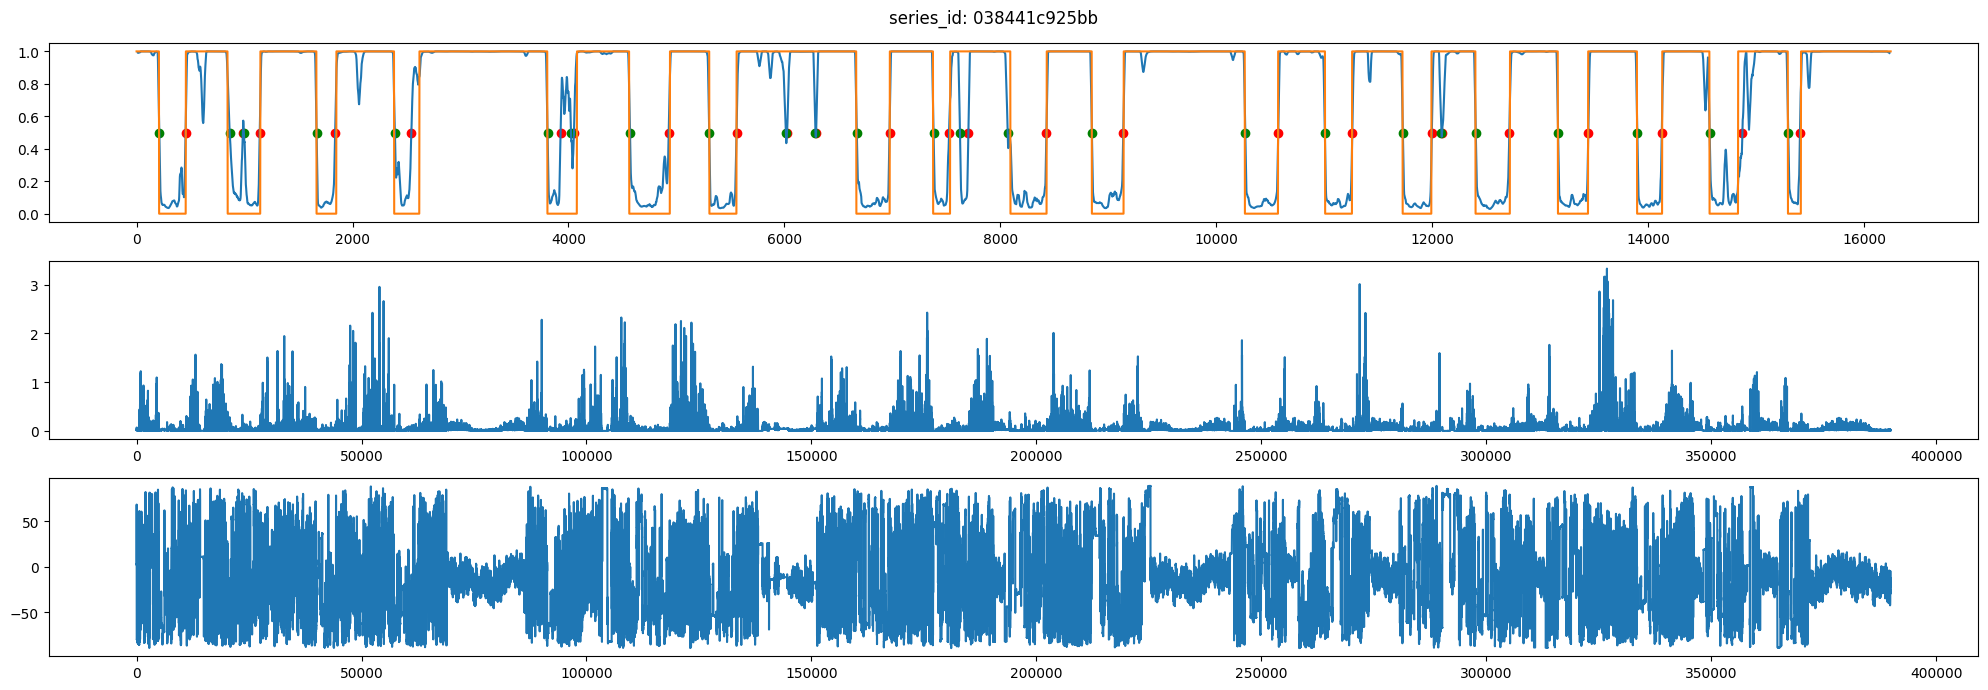

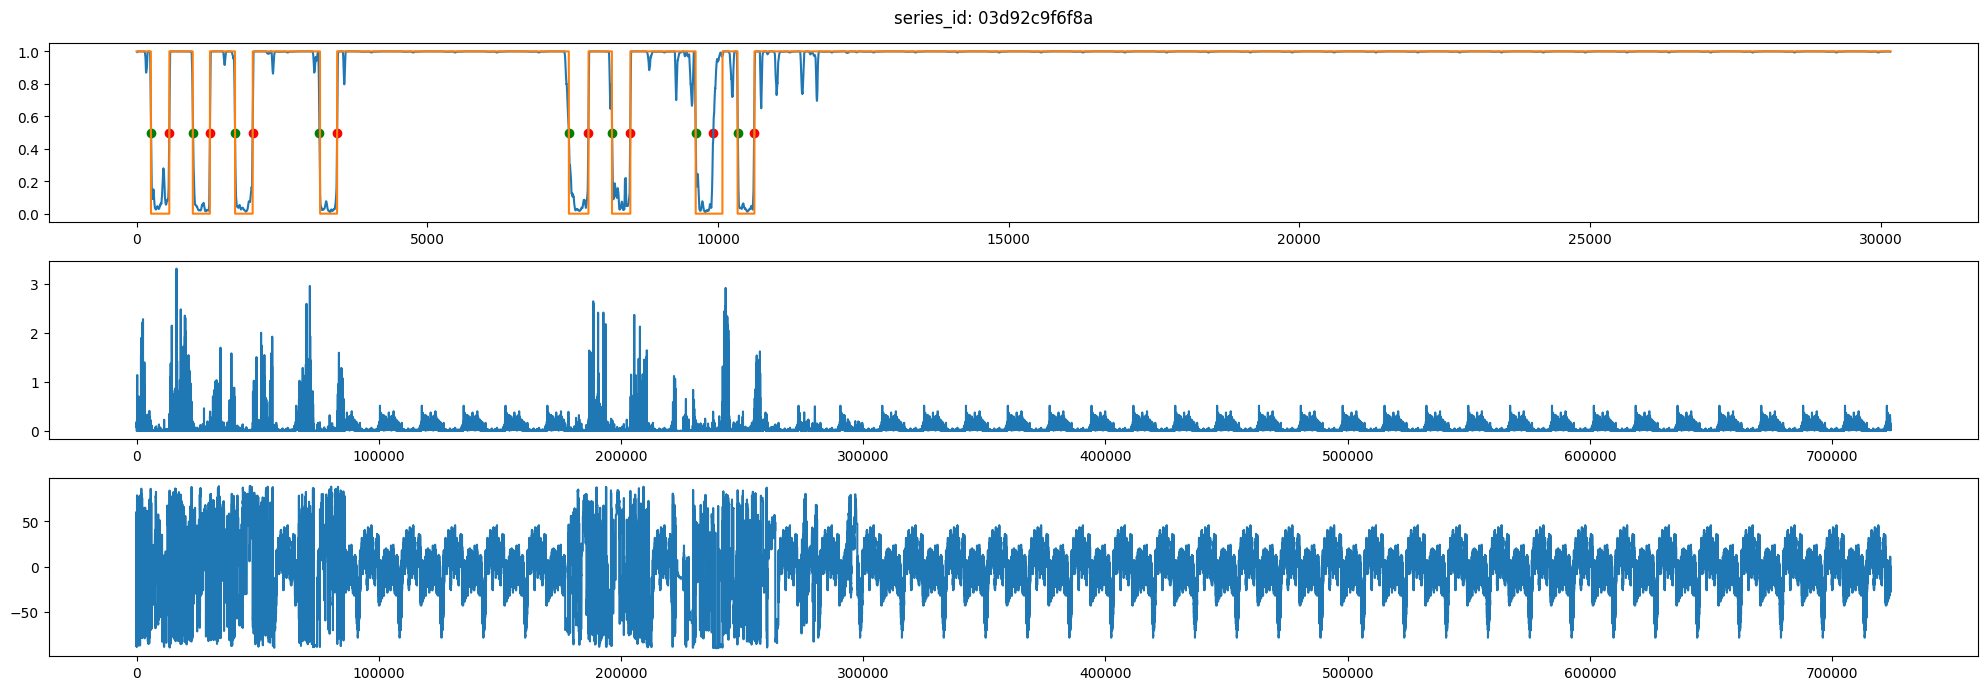

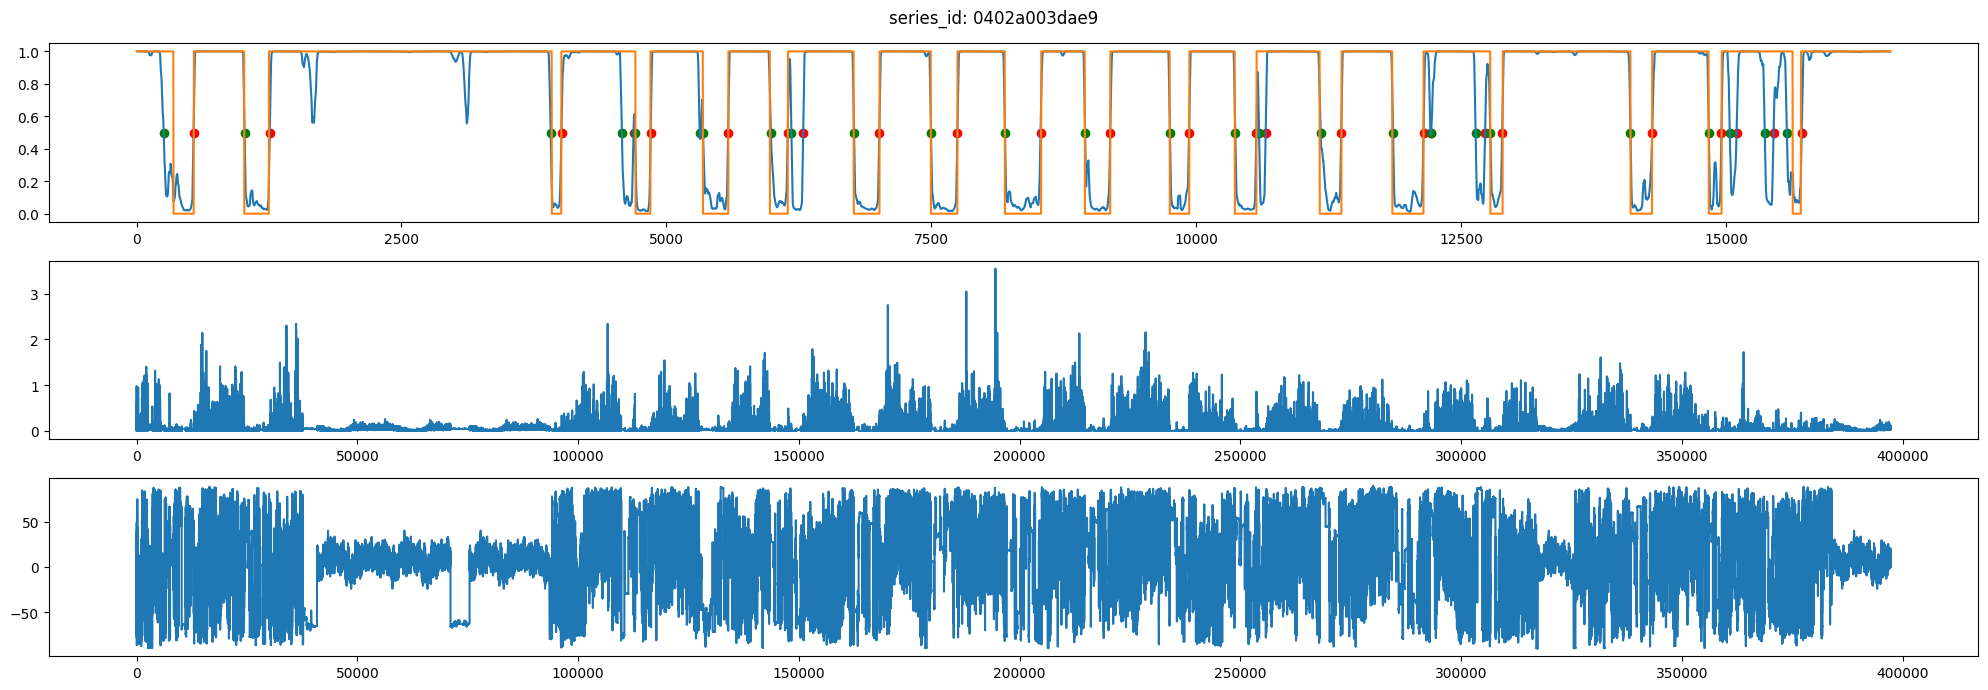

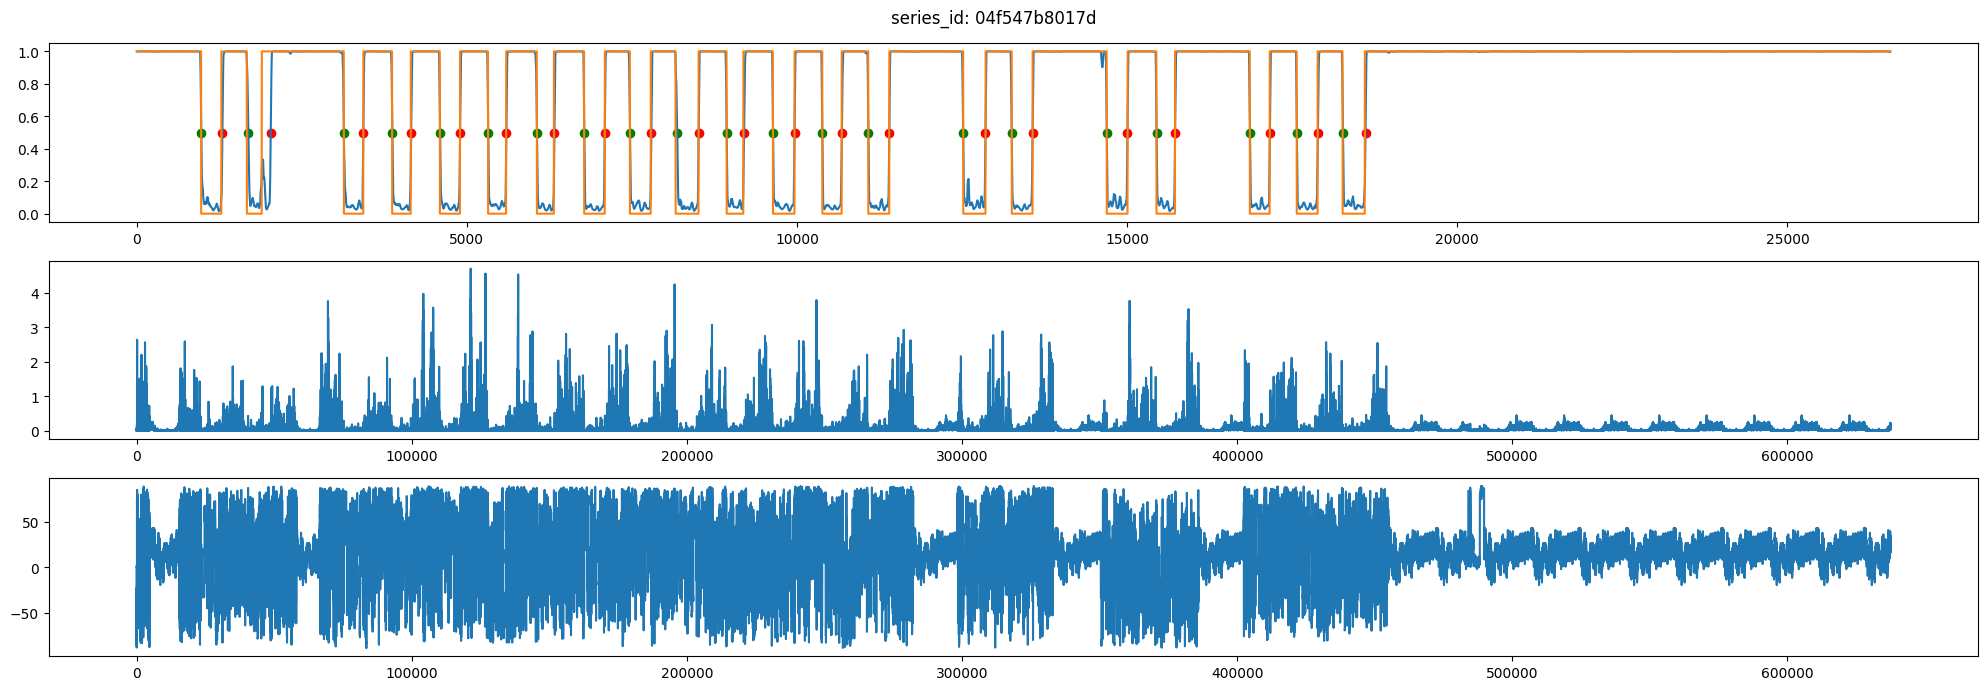

,series_id,step,event,score
0,038441c925bb,10895,wakeup,1
1,038441c925bb,23639,wakeup,1
2,038441c925bb,27383,wakeup,1
3,038441c925bb,44159,wakeup,1
4,038441c925bb,61079,wakeup,1


In [10]:
dfs = []
oofs = []
for series_id, df in train.groupby("series_id"):
    df = df.reset_index(drop=True)
    df["raw_oof"] = df["oof"]
    df["oof"] = df["oof"].rolling(24, center=True).mean()
    oofs.append(df)
    wakeup_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i-1] < 0.5 and df["oof"][i] >= 0.5])
    onset_index = np.array([i for i in range(1, len(df["oof"])) if df["oof"][i-1] > 0.5 and df["oof"][i] <= 0.5])

    sub = pd.concat([
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[wakeup_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "wakeup",
            "score": 1,
        }) if len(wakeup_index) > 0 else pd.DataFrame(),
        pd.DataFrame({
            "series_id": series_id,
            "step": df["step"].values[onset_index] - CFG["feature"]["agg_freq"] // 2,
            "event": "onset",
            "score": 1,
        }) if len(onset_index) > 0 else pd.DataFrame(),
    ])
    if len(sub) > 0:
        sub["step"] = sub["step"].astype(int)
        dfs.append(sub)

    if len(dfs) < 5:
        fig, axs = plt.subplots(3, 1, figsize=(20, 7))
        axs[0].plot(df["oof"])
        axs[0].plot(df["target"])
        axs[0].scatter(wakeup_index, [0.5 for _ in wakeup_index], c="red")
        axs[0].scatter(onset_index, [0.5 for _ in onset_index], c="green")
        df = pd.read_csv(f"{CFG['dataset']['step_csv_dir']}/{df['series_id'].values[0]}.csv")
        axs[1].plot(df["enmo"])
        axs[2].plot(df["anglez"])
        plt.suptitle(f"series_id: {series_id}")
        plt.tight_layout()
        plt.show()

train = pd.concat(oofs)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)
sub = pd.concat(dfs).reset_index(drop=True)
sub.head()

score: 0.3816


event   tolerance
onset   12           0.003305
        36           0.030926
        60           0.093557
        90           0.212057
        120          0.358984
        150          0.447118
        180          0.519155
        240          0.591935
        300          0.629518
        360          0.652077
wakeup  12           0.008298
        36           0.079692
        60           0.187266
        90           0.333134
        120          0.426975
        150          0.507260
        180          0.558524
        240          0.631808
        300          0.668761
        360          0.691062
dtype: float64

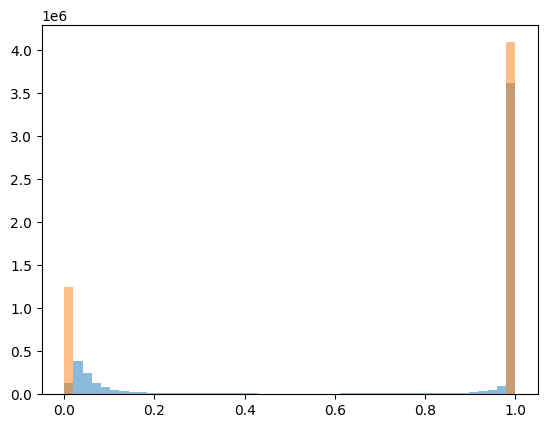

In [11]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
plt.hist(train["oof"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 1, 50), alpha=0.5)
plt.show()

In [12]:
# 次の候補の大きさ
next_cand_size = 0
count = 0
next_dict = {}
for series_id, train_df in train.groupby("series_id"):
    train_df = train_df[(train_df["oof"] >= 0.1) & (train_df["oof"] <= 0.9)]
    sub_df = sub[(sub["series_id"] == series_id)]
    label_df = labels[labels["series_id"] == series_id]
    pred_steps = train_df["step"].values
    sub_steps = sub_df["step"].values
    label_steps = label_df["step"].values

    if len(train_df) == 0:
        continue
    next_cand = np.zeros(int(max(max(pred_steps if len(pred_steps) > 0 else [0]), max(sub_steps if len(sub_steps) > 0 else [0]))) + CFG["feature"]["agg_freq"])
    for sub_step in sub_steps:
        next_cand[int(sub_step - CFG["feature"]["agg_freq"] * 5): int(sub_step + CFG["feature"]["agg_freq"] * 5)] = 1
    for pred_step in pred_steps:
        next_cand[int(pred_step - CFG["feature"]["agg_freq"] * 5): int(pred_step + CFG["feature"]["agg_freq"] * 5)] = 1
    next_cand_size += np.sum(next_cand)
    next_dict[series_id] = np.where(next_cand)[0]

    for label_step in label_steps:
        if label_step < next_cand.shape[0]:
            count += next_cand[int(label_step)]
    
recall = count / len(labels)
print(f"recall: {recall:.4f}")
print(f"next_cand_size: {next_cand_size}")

recall: 0.9649
next_cand_size: 16213008.0


In [13]:
import pickle

with open(f"{CFG['output_dir']}/next_cands.pkl", "wb") as f:
    pickle.dump(next_dict, f)